In [1]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=0214f8a7e9aa01bcbbae6ddbcecf3a1b6919acf46a9b1b25227fc32a71bc337b
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [37]:
import os
import re

from collections import Counter

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import swifter
import nltk

from nltk.corpus import stopwords
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from wordcloud import WordCloud
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
os.environ["WANDB_DISABLED"] = "true"  # Trainer stalls on kaggle otherwise

In [4]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [5]:
df.shape

(50000, 2)

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df = df.rename(columns={'review': 'text', 'sentiment': 'label'})

In [8]:
def clean_text(text):
    cleaned_text = re.sub(r'<.*?>', '', text)
    return cleaned_text

In [9]:
df.text = df.text.swifter.apply(clean_text)
df.label = df.label.swifter.apply(lambda x: 0 if x == 'positive' else 1)

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

In [10]:
word_count = df.text.swifter.apply(lambda x: len(str(x).split()))

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

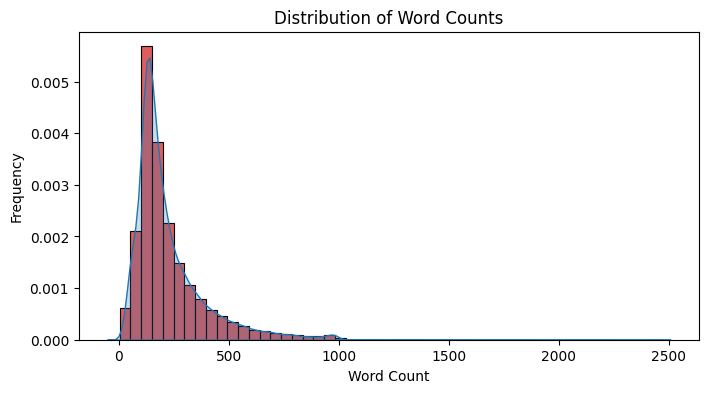

In [11]:
plt.figure(figsize=(8, 4))
sns.histplot(word_count, bins=50, color='#D62728', stat='density')
sns.kdeplot(word_count, color='#1F77B4', fill=True)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [12]:
# Remove stopwords and count word frequencies
stop_words = set(stopwords.words('english'))
words = ' '.join(df.text).split()
words = [word for word in words if word.lower() not in stop_words]
word_freq = Counter(words)

# Get the most common words
most_common_words = word_freq.most_common(20)

In [13]:
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

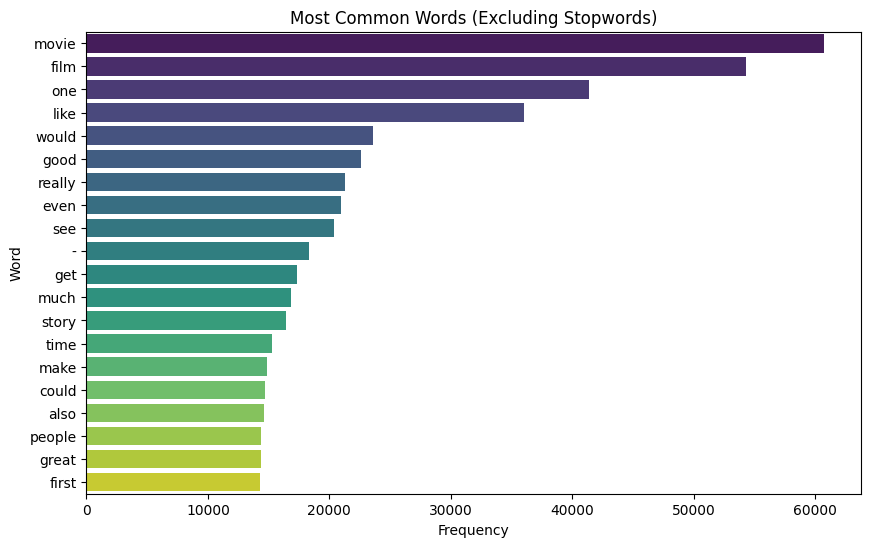

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=common_words_df, palette='viridis')
plt.title('Most Common Words (Excluding Stopwords)')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

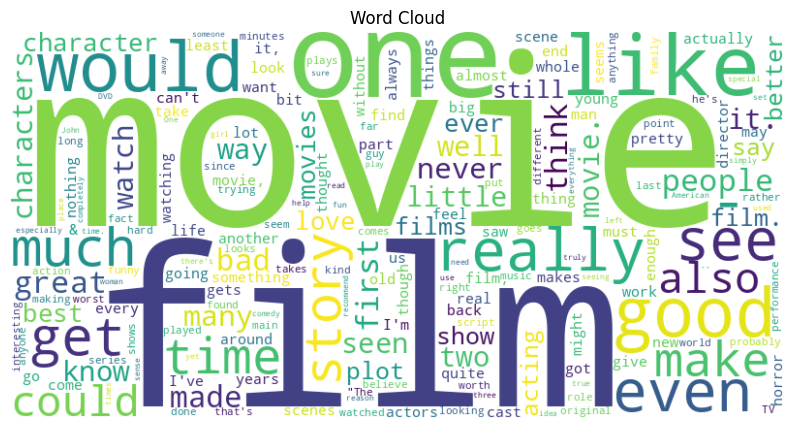

In [15]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

In [16]:
dataset = Dataset.from_pandas(df)

In [17]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True, batch_size=2000, num_proc=os.cpu_count())

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

In [18]:
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)

In [19]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    fp16=True,
    evaluation_strategy='epoch'
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split['train'],
    eval_dataset=train_test_split['test'],
)

In [22]:
trainer.train() 

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.271400,0.203882
2,0.153300,0.195265
3,0.050800,0.257922


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1875, training_loss=0.18191292568047843, metrics={'train_runtime': 3579.2153, 'train_samples_per_second': 33.527, 'train_steps_per_second': 0.524, 'total_flos': 1.589608783872e+16, 'train_loss': 0.18191292568047843, 'epoch': 3.0})

In [23]:
evaluation_results = trainer.evaluate()
print(evaluation_results)

{'eval_loss': 0.25792166590690613, 'eval_runtime': 95.7476, 'eval_samples_per_second': 104.441, 'eval_steps_per_second': 1.64, 'epoch': 3.0}


In [25]:
 # Unfortunately we overfit -- loading best weights should've been implemented but training time is long
 # and I'm running out of free GPU time xD

In [26]:
predictions = trainer.predict(train_test_split['test'])
preds = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

In [28]:
cm = confusion_matrix(true_labels, preds)

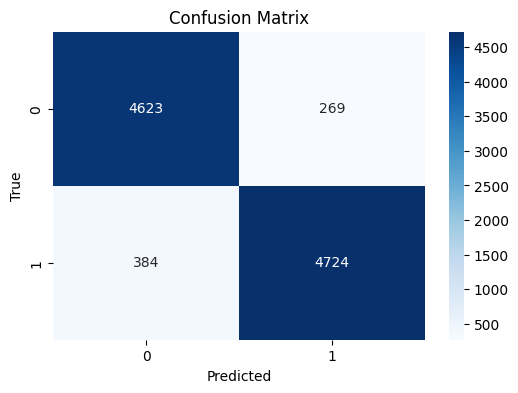

In [30]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [31]:
y_scores = predictions.predictions[:, 1]

fpr, tpr, thresholds = roc_curve(true_labels, y_scores)
roc_auc = roc_auc_score(true_labels, y_scores)

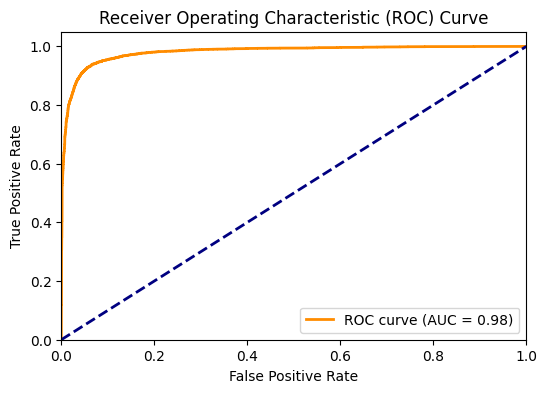

In [33]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [36]:
report = classification_report(true_labels, preds)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93      4892
           1       0.95      0.92      0.94      5108

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

